#### Import modules and read data

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

# from shapely.geometry import LineString

In [2]:
df = pd.read_csv(os.getcwd() + '/Data/btc.csv')
df.shape

(4568, 140)

Data source and metrics info: [Coin Metrics](https://tools.coinmetrics.io/)

In [3]:
df.tail()

,date,AdrActCnt,AdrBal1in100KCnt,AdrBal1in100MCnt,AdrBal1in10BCnt,AdrBal1in10KCnt,AdrBal1in10MCnt,AdrBal1in1BCnt,AdrBal1in1KCnt,AdrBal1in1MCnt,...,TxTfrCnt,TxTfrValAdjNtv,TxTfrValAdjUSD,TxTfrValMeanNtv,TxTfrValMeanUSD,TxTfrValMedNtv,TxTfrValMedUSD,VelCur1yr,VtyDayRet180d,VtyDayRet30d
4563,2021-07-02,809016,9350,2208096,16047842,1076,467134,6740169,48,99721,...,627111,295299.192460,9.976077e+09,0.937622,31675.633215,0.005090,171.955195,11.589896,0.047383,0.050807
4564,2021-07-03,1027108,9343,2208198,15922411,1076,467292,6724192,48,99656,...,700266,141134.301445,4.881585e+09,0.574656,19876.316817,0.003535,122.265914,11.582681,0.047292,0.050420
4565,2021-07-04,843475,9349,2206856,15835818,1075,467194,6707328,48,99632,...,529255,136087.309361,4.811450e+09,0.883479,31235.925922,0.003720,131.536296,11.563401,0.047055,0.049506
4566,2021-07-05,902032,9351,2206469,15789347,1076,467213,6699639,48,99622,...,651348,166247.950794,5.637760e+09,0.522203,17708.817433,0.004306,146.028081,11.590388,0.046827,0.049530
4567,2021-07-06,853332,9358,2209025,15803599,1075,467313,6698688,49,99660,...,702385,181090.983977,6.179545e+09,0.571996,19518.767813,0.004846,165.359184,11.581377,0.046550,0.049515


#### Data processing

In [4]:
df['date'] = pd.to_datetime(df['date'])  # convert date from object to timestamp

df = df.reset_index(drop = True).set_index('date')  # set date as dataframe index

In [5]:
df = df['2013' :]  # fiter to keep data from 2013 onwards 
df.shape

(3109, 139)

Although the first Bitcoin was mined by Satoshi Nakamoto on 2009-01-03, I'm using data ony from 2013 as before that, there wasn't any consistent tracking of BTC metrics.

In [6]:
keep = ['AdrActCnt', 'AdrBal1in10KCnt', 'AdrBalCnt', 'CapMrktCurUSD', 'DiffLast', 'FlowInExNtv', 'FlowOutExNtv', 'HashRate', 'NDF', 'RevHashNtv', 'TxCnt', 'PriceUSD']  # attributes to use to create an aggregate growth metric
df = df[keep]

df.head()

,AdrActCnt,AdrBal1in10KCnt,AdrBalCnt,CapMrktCurUSD,DiffLast,FlowInExNtv,FlowOutExNtv,HashRate,NDF,RevHashNtv,TxCnt,PriceUSD
date,,,,,,,,,,,,
2013-01-01,38733,956,1083334,1.415537e+08,2.979637e+06,2025.232892,3971.570665,23.995203,0.414952,0.001966,32892,13.331371
2013-01-02,40911,956,1087256,1.410655e+08,2.979637e+06,6236.180677,7127.091305,22.662137,0.415285,0.001969,37619,13.280607
2013-01-03,52539,952,1094193,1.422188e+08,2.979637e+06,7369.853274,7211.470345,23.995203,0.414465,0.001972,43533,13.384081
2013-01-04,46781,952,1098470,1.429890e+08,2.979637e+06,7791.647509,6683.430401,22.662137,0.414825,0.001973,47370,13.451721
2013-01-05,53959,957,1105085,1.431181e+08,2.979637e+06,11248.100591,7446.787760,20.884714,0.414961,0.001971,39811,13.459407


#### Exploratory data analysis

1. PriceUSD

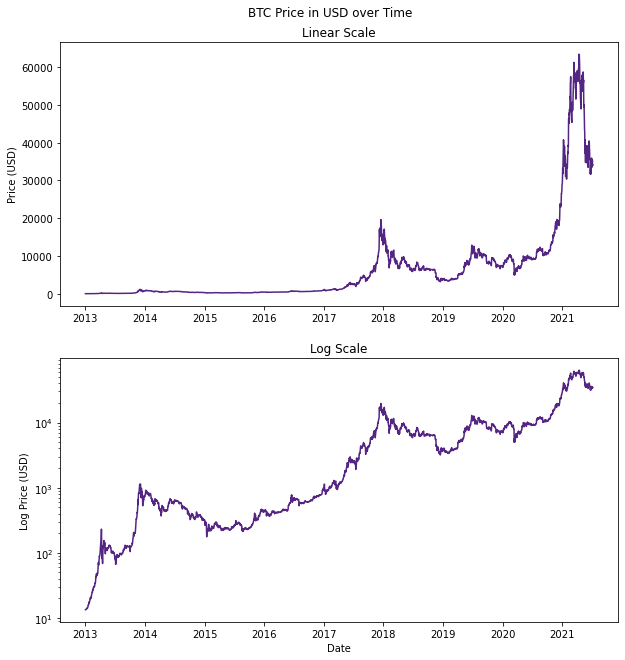

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = False, figsize = (10, 10))
fig.suptitle('BTC Price in USD over Time')

ax1.plot(df.index, df['PriceUSD'], color = '#552583')
ax1.set_title('Linear Scale')
ax1.set_ylabel('Price (USD)')

ax2.plot(df.index, df['PriceUSD'], color = '#552583')
ax2.set_yscale('log')
ax2.set_title('Log Scale')
ax2.set_xlabel('Date')
ax2.set_ylabel('Log Price (USD)')

plt.subplots_adjust(top = 0.93)
plt.show()
plt.close()

Observations:

1. The linear scale makes it easy to see the price of BTC increase in late 2017, followed by a drop after that, and the next major increase in 2021. 

2. The log scale makes it easy to see the smaller price changes that took place in 2013 and 2014, the slow increase between 2016 and 2018, while reducing the skewness of the line towards larger values seen in 2018 and 2021. The price change over time looks _almost_ linear. 

In [8]:
def eda_plots(x, y, title, x_lab, y_lab, log_scale = False):  # function to plot attributes from the dataframe
    plt.plot(x, y, color = '#552583')
    if log_scale:
        plt.yscale('log')
    plt.title(title)
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()
    plt.close()

Transformations applied for some attributes: 
    
* 7-day rolling mean: helps smoothen the curve and reduce noise

* log transformation: helps amplify smaller changes that may not be as easy to notice on a linear scale

2. AdrActCnt

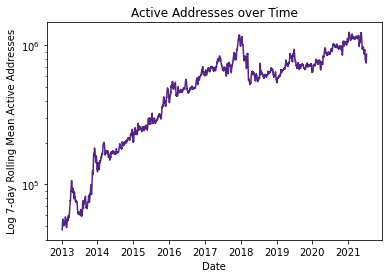

In [9]:
eda_plots(df.index, df['AdrActCnt'].rolling(7).mean(), 'Active Addresses over Time', 'Date', 'Log 7-day Rolling Mean Active Addresses', True)

Observations: As expected, the number of active addresses each day has generally increased over time as Bitcoin became more popular, with noticeabe drops in 2018 and 2021 when BTC prices fell.

3. AdrBal1in10KCnt

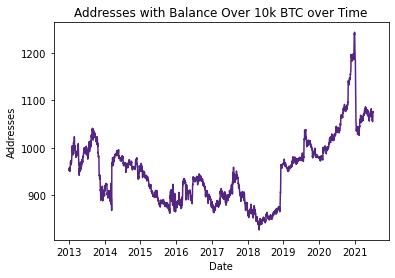

In [10]:
eda_plots(df.index, df['AdrBal1in10KCnt'], 'Addresses with Balance Over 10k BTC over Time', 'Date', 'Addresses')

Observations: 

4. AdrBalCnt

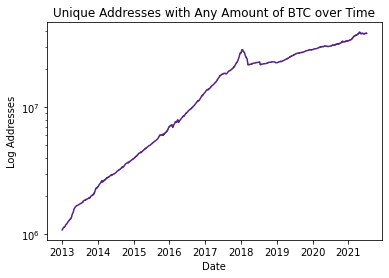

In [11]:
eda_plots(df.index, df['AdrBalCnt'], 'Unique Addresses with Any Amount of BTC over Time', 'Date', 'Log Addresses', True)

Observations: An growing trend with a clear spike visible even on the log scale during the 2018 bull run.

5. CapMrktCurUSD

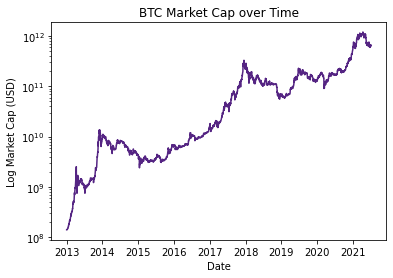

In [12]:
eda_plots(df.index, df['CapMrktCurUSD'], 'BTC Market Cap over Time', 'Date', 'Log Market Cap (USD)', True)

Observations: As market cap is the product of supply and price, this graph is effectively a scaled-up graph of BTC price over time. Market cap will not be used as an input variable for the aggregate growth metric.

6. DiffLast

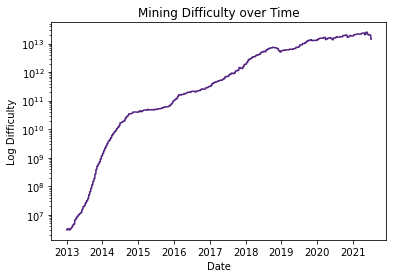

In [13]:
eda_plots(df.index, df['DiffLast'], 'Mining Difficulty over Time', 'Date', 'Log Difficulty', True)

Observations: With an increasing number of miners over time, an increasing difficulty is observed to keep the block time around 10 minutes

7. FlowInExNtv

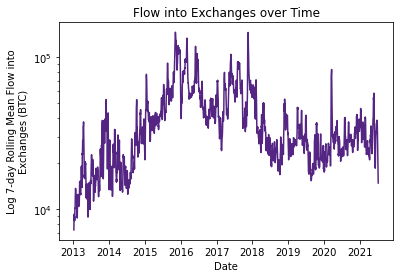

In [14]:
eda_plots(df.index, df['FlowInExNtv'].rolling(7).mean(), 'Flow into Exchanges over Time', 'Date', 'Log 7-day Rolling Mean Flow into\nExchanges (BTC)', True)

8. FlowOutExNtv

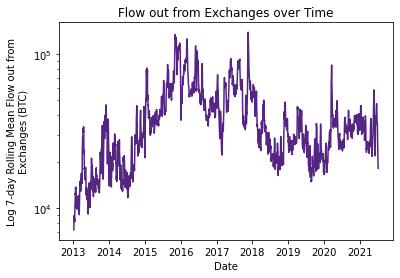

In [15]:
eda_plots(df.index, df['FlowOutExNtv'].rolling(7).mean(), 'Flow out from Exchanges over Time', 'Date', 'Log 7-day Rolling Mean Flow out from\nExchanges (BTC)', True)

9. HashRate

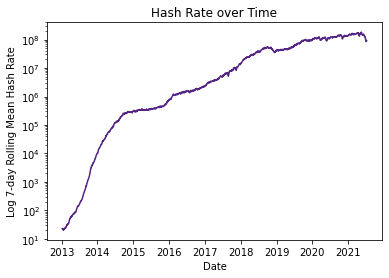

In [16]:
eda_plots(df.index, df['HashRate'].rolling(7).mean(), 'Hash Rate over Time', 'Date', 'Log 7-day Rolling Mean Hash Rate', True)

Observations: As expected, while the absolute values differ, the shape of the plot of the hash rate over time is extremely similar to that of the mining difficulty.

10. NDF

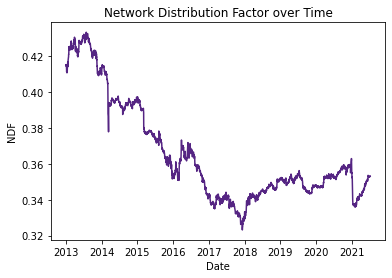

In [17]:
eda_plots(df.index, df['NDF'], 'Network Distribution Factor over Time', 'Date', 'NDF')

11. RevHashNtv

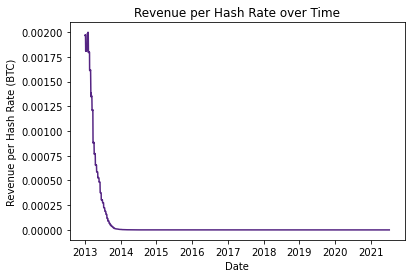

In [18]:
eda_plots(df.index, df['RevHashNtv'], 'Revenue per Hash Rate over Time', 'Date', 'Revenue per Hash Rate (BTC)')

12. TxCnt

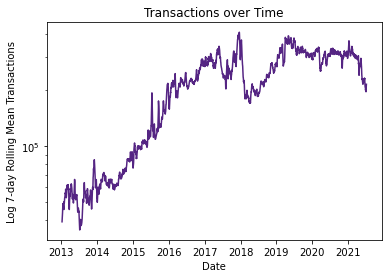

In [19]:
eda_plots(df.index, df['TxCnt'].rolling(7).mean(), 'Transactions over Time', 'Date', 'Log 7-day Rolling Mean Transactions', True)

Correlation matrix:

In [20]:
corr_matrix = df.corr()

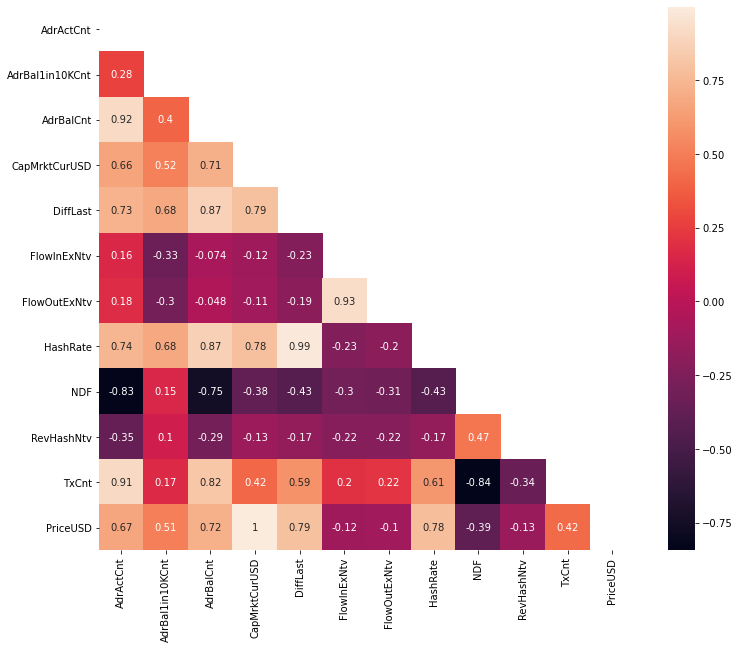

In [21]:
mask = np.triu(np.ones_like(corr_matrix, dtype = bool))

plt.figure(figsize = (12, 10))
sns.heatmap(corr_matrix, mask = mask, annot = True)
plt.show()
plt.close()

#### An aggregate growth metric for Bitcoin

HashRate has a high correlation value (0.78), hence we can attempt to use a hash ribbon as an indicator.

Miner capitulation occurs when Bitcoin mining is no longer profitable. Due to the emergence of mining pools and other large-scale mining centres, a short-term slump in BTC price will not lead to a drastic drop in hash rate in the network.

When the 30-day moving average of the hash rate crosses above the 60-day moving average, the hash ribbon indicator tends to signal the end of miner capitulation, and a return to a growing market.

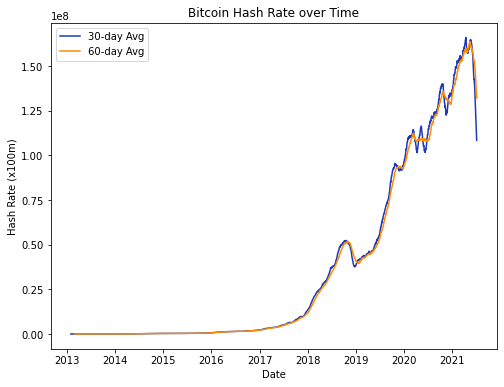

In [30]:
plt.figure(figsize = (8, 6))

plt.plot(df.index, df['HashRate'].rolling(30).mean(), color = '#1c39bb', label = '30-day Avg')
plt.plot(df.index, df['HashRate'].rolling(60).mean(), color = '#ff8b00', label = '60-day Avg')
# plt.yscale('log')
plt.title('Bitcoin Hash Rate over Time')
plt.xlabel('Date')
plt.ylabel('Hash Rate (x100m)')
plt.legend()
plt.show()
plt.close()

2018 was when the hash rate increased significantly. Replotting the same graph from 2018 onwards and overlaying price:

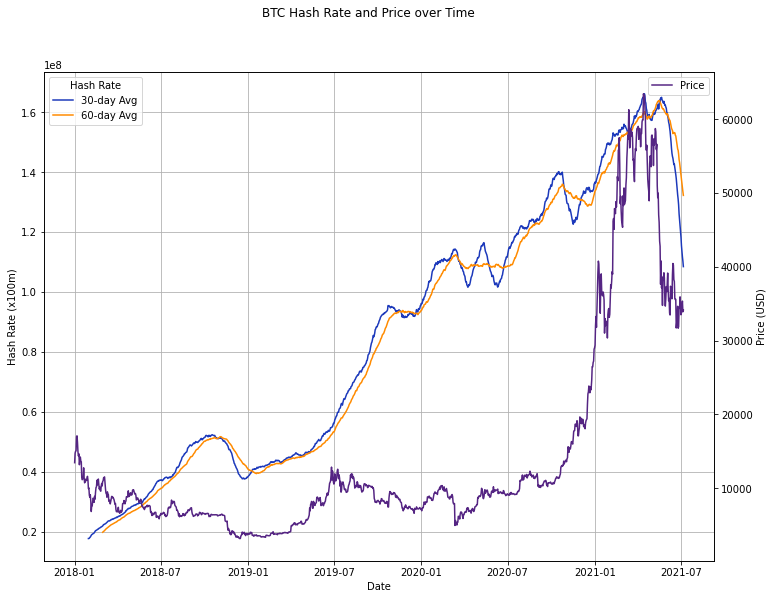

In [37]:
year = '2018'

fig, ax1 = plt.subplots(figsize = (12, 9))
fig.suptitle('BTC Hash Rate and Price over Time')

ax1.plot(df[year :].index, df[year :]['HashRate'].rolling(30).mean(), color = '#1c39bb', label = '30-day Avg')
ax1.plot(df[year :].index, df[year :]['HashRate'].rolling(60).mean(), color = '#ff8b00', label = '60-day Avg')
ax1.set_xlabel('Date')
ax1.set_ylabel('Hash Rate (x100m)')
ax1.grid()
plt.legend(title = 'Hash Rate')

ax2 = ax1.twinx()
ax2.plot(df[year :].index, df[year :]['PriceUSD'], color = '#552583', label = 'Price')
ax2.set_ylabel('Price (USD)')
plt.legend()

plt.show()
plt.close()

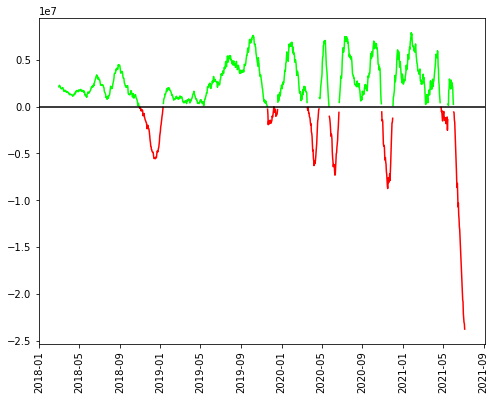

In [45]:
avg_diff = (df[year :]['HashRate'].rolling(30).mean() - df[year :]['HashRate'].rolling(60).mean()).dropna()

plt.figure(figsize = (8, 6))

lower = np.ma.masked_where(avg_diff < 0, avg_diff)
upper = np.ma.masked_where(avg_diff > 0, avg_diff)

plt.plot(avg_diff.index, upper, color = '#ff0000')
plt.plot(avg_diff.index, lower, color = '#00ff00')
plt.axhline(0, color = '#000000')
plt.xticks(rotation = 90)
plt.show()
plt.close()

In [46]:
upper

masked_array(data=[--, --, --, ..., -23057824.39658974,
                   -23153170.526461005, -23758018.653773427],
             mask=[ True,  True,  True, ..., False, False, False],
       fill_value=1e+20)